In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [4]:
import cv2

# Read the image in grayscale
image = cv2.imread('../images/latest_1024_HMIIF.jpg', cv2.IMREAD_GRAYSCALE)

# Convert the image to a numpy array (cv2.imread already returns a numpy array)
image_array = np.array(image)
image_array.shape

(1024, 1024)

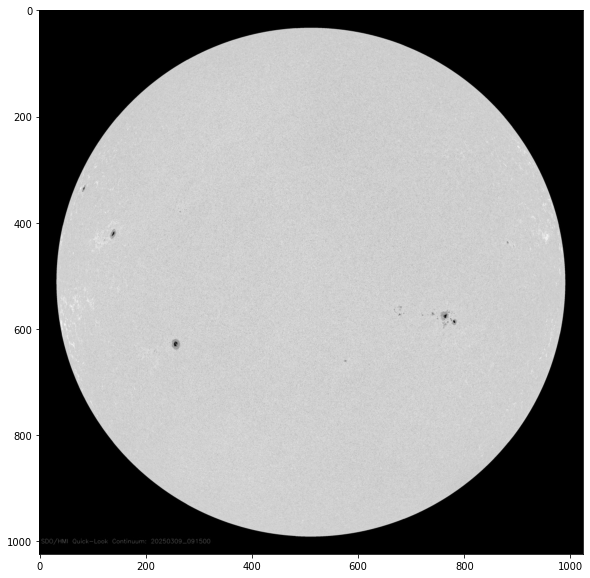

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(image_array, cmap='gray')

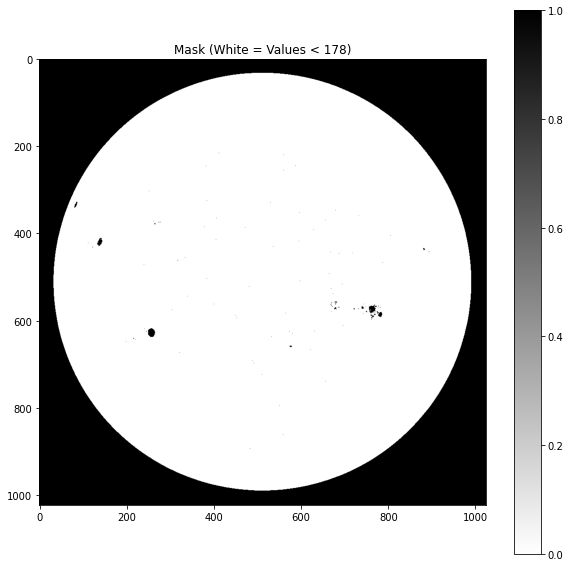

In [180]:
# Create mask where values are lower than some threshold
threshold = 178
mask = image_array < threshold

# Visualize the mask
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='binary')
plt.title(f'Mask (White = Values < {threshold})')
plt.colorbar()

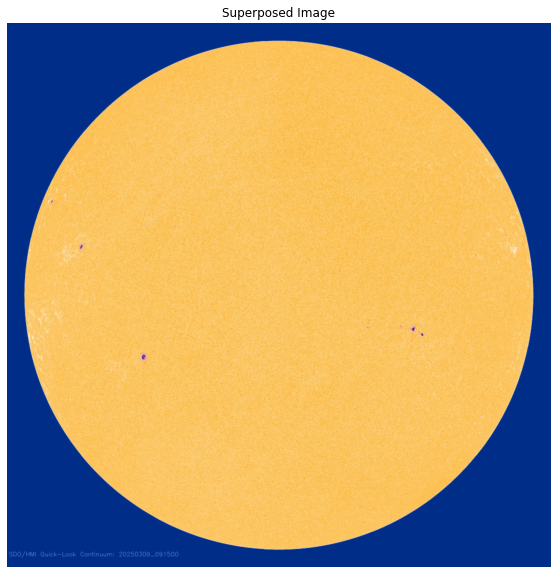

In [ ]:
# Import original image in color
image_color = cv2.imread('../images/latest_1024_HMIIF.jpg', cv2.IMREAD_COLOR)

# Create a red mask
color_mask = np.zeros_like(image_color)
color_mask[mask, :] = [150, 50, 0]  #Great contrast

# Superpose the red mask on the original image with some transparency
alpha = 0.9
superposed_image = cv2.addWeighted(image_color, 1, color_mask, alpha, 0)

# Save the resulting image
#cv2.imwrite('results/superposed_image.png', superposed_image)

# Display the resulting image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(superposed_image, cv2.COLOR_BGR2RGB))
plt.title('Superposed Image')
plt.axis('off')
plt.show()

In [182]:
cv2.imwrite('results/color_mask.png', color_mask)

True

In [183]:
import skimage.measure as skm
labels = skm.label(color_mask, connectivity=2, background=0)

In [184]:
regionprops = skm.regionprops(labels)
regionprops = [regionprop for regionprop in regionprops if  10000 >= regionprop.area_filled >= 7]
#Eliminate small regions that are probably outliers, and the big region that is the background

In [185]:
print(f'Number of sunspots: {len(regionprops)//2}')
print('')
for i in range(len(regionprops)):
    if i%2 == 0: #For some reason each label is repeated 
        print(f'Sunspot {i//2 + 1}: {int(regionprops[i].area_filled)} pixels')

Number of sunspots: 14

Sunspot 1: 45 pixels
Sunspot 2: 130 pixels
Sunspot 3: 13 pixels
Sunspot 4: 12 pixels
Sunspot 5: 201 pixels
Sunspot 6: 23 pixels
Sunspot 7: 15 pixels
Sunspot 8: 14 pixels
Sunspot 9: 74 pixels
Sunspot 10: 8 pixels
Sunspot 11: 8 pixels
Sunspot 12: 18 pixels
Sunspot 13: 250 pixels
Sunspot 14: 14 pixels


In [186]:
# import skimage.segmentation as sks
# import skimage.draw as skd

# # Create a mask for the borders
# border_mask = np.zeros_like(color_mask)

# # Draw bounding boxes around each sunspot
# for i, region in enumerate(regionprops):
#     if i % 2 == 0:  # Skip duplicate regions
#         # print(region.bbox)
#         minr, minc, _, maxr, maxc, _ = region.bbox
#         # Draw rectangle using straight lines
#         # Horizontal lines
#         border_mask[minr:maxr, minc, :] = [255, 100, 0]  # Blue color in BGR
#         border_mask[minr:maxr, maxc, :] = [255, 100, 0]
#         # Vertical lines
#         border_mask[minr, minc:maxc, :] = [255, 100, 0]
#         border_mask[maxr, minc:maxc+1, :] = [255, 100, 0]

# # Create kernel for dilation
# kernel = np.ones((2,2), np.uint8)  # Increased kernel size for thicker lines
# # Dilate the borders to make them thicker
# dilated_borders = cv2.dilate(border_mask, kernel, iterations=1)

# # Superpose the blue borders on the original image
# border_superposed = cv2.addWeighted(image_color, 1, dilated_borders, alpha, 0)

# # Display the result
# plt.figure(figsize=(15, 15))
# plt.imshow(cv2.cvtColor(border_superposed, cv2.COLOR_BGR2RGB))
# plt.title('Sunspots Bounding Boxes')
# plt.axis('off')
# plt.show()

# # Save the resulting image
# cv2.imwrite('results/border_superposed.png', border_superposed)

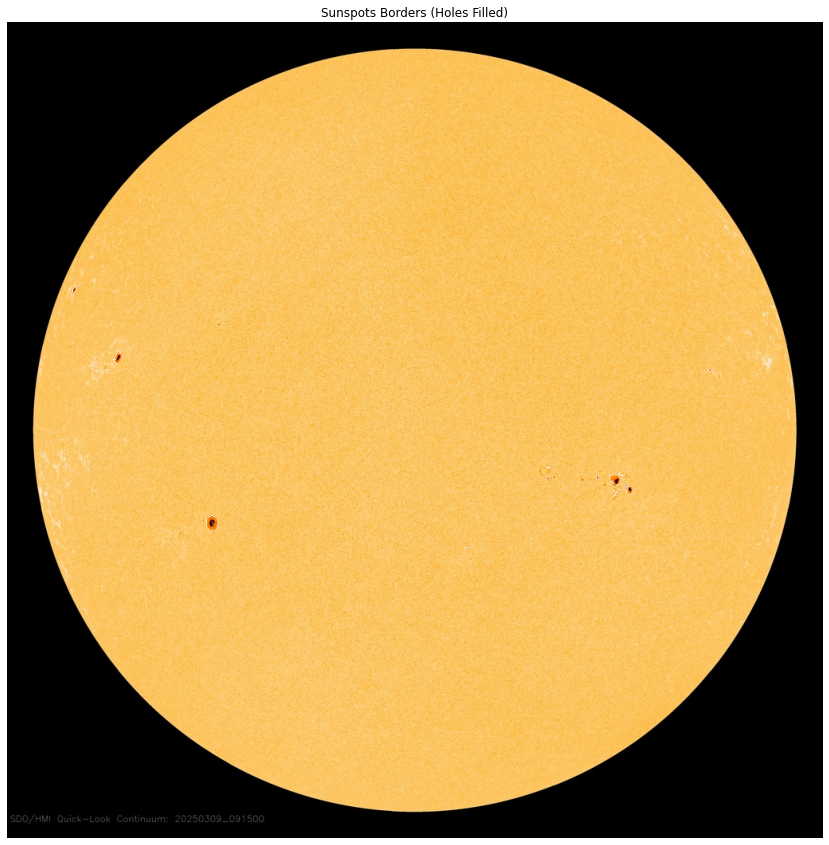

True

In [ ]:
# Create a mask for the borders
border_mask = np.zeros_like(color_mask)

# Draw borders around each sunspot
for i, region in enumerate(regionprops):
    if i % 2 == 0:  # Skip duplicate regions
        filled_area = region.filled_image
        coords = region.coords
        minr, minc, _, maxr, maxc, _ = region.bbox
        
        # Create a temporary mask for this region
        temp_mask = np.zeros((maxr - minr + 1, maxc - minc + 1), dtype=bool)
        # Fill the mask with the filled area
        temp_mask[0:filled_area.shape[0], 0:filled_area.shape[1]] = filled_area[:,:,0]
        
        # Find the boundary pixels
        for x in range(temp_mask.shape[0]):
            for y in range(temp_mask.shape[1]):
                if temp_mask[x, y]:
                    # Check if this pixel is on the boundary
                    if (x == 0 or x == temp_mask.shape[0]-1 or 
                        y == 0 or y == temp_mask.shape[1]-1 or
                        not temp_mask[x-1, y] or not temp_mask[x+1, y] or
                        not temp_mask[x, y-1] or not temp_mask[x, y+1]):
                        # Map back to original coordinates
                        border_mask[x + minr, y + minc] = [255, 100, 0]


# Superpose the blue borders on the original image
border_superposed = cv2.addWeighted(image_color, 1, border_mask, alpha, 0)

# Display the result
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(border_superposed, cv2.COLOR_BGR2RGB))
plt.title('Sunspots Borders with Method 1')
plt.axis('off')
plt.show()

# Save the resulting image
cv2.imwrite('results/border_superposed.png', border_superposed)

In [ ]:
# Calculate mean intensity considering only pixels with intensity > 100
bright_pixels = image_array[image_array > 100]
mean_intensity = np.mean(bright_pixels)

1

Final pipeline

In [ ]:
def main(input_path, output_folder = 'results/', threshold_ratio=0.88):
    # Read the image in grayscale
    image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    image_array = np.array(image)

    # Also import original image in color
    image_color = cv2.imread(input_path, cv2.IMREAD_COLOR)

    # Calculate mean intensity considering only pixels with intensity > 100
    bright_pixels = image_array[image_array > 100]
    mean_intensity = np.mean(bright_pixels)

    # Calculate threshold as alpha * mean_intensity
    # The threshold is proportional to the intensity of the sun for better robustness
    threshold = round(threshold_ratio * mean_intensity)

    # Creates the mask of estimated sunspots
    mask = image_array < threshold

    labels = skm.label(mask, connectivity=2, background=0)
    regionprops = skm.regionprops(labels)
    regionprops = [regionprop for regionprop in regionprops if  10000 >= regionprop.area_filled >= 7]

    # Create a mask for the borders
    border_mask = np.zeros_like(color_mask)

    # Draw borders around each sunspot
    for i, region in enumerate(regionprops):
        if i % 2 == 0:  # Skip duplicate regions
            filled_area = region.filled_image
            coords = region.coords
            minr, minc, _, maxr, maxc, _ = region.bbox
            
            # Create a temporary mask for this region
            temp_mask = np.zeros((maxr - minr + 1, maxc - minc + 1), dtype=bool)
            # Fill the mask with the filled area
            temp_mask[0:filled_area.shape[0], 0:filled_area.shape[1]] = filled_area[:,:,0]
            
            # Find the boundary pixels
            for x in range(temp_mask.shape[0]):
                for y in range(temp_mask.shape[1]):
                    if temp_mask[x, y]:
                        # Check if this pixel is on the boundary
                        if (x == 0 or x == temp_mask.shape[0]-1 or 
                            y == 0 or y == temp_mask.shape[1]-1 or
                            not temp_mask[x-1, y] or not temp_mask[x+1, y] or
                            not temp_mask[x, y-1] or not temp_mask[x, y+1]):
                            # Map back to original coordinates
                            border_mask[x + minr, y + minc] = [255, 100, 0]


    # Superpose the blue borders on the original image
    border_superposed = cv2.addWeighted(image_color, 1, border_mask, alpha, 0)

    # Display the result
    plt.figure(figsize=(15, 15))
    plt.imshow(cv2.cvtColor(border_superposed, cv2.COLOR_BGR2RGB))
    plt.title('Sunspots Borders with Method 1')
    plt.axis('off')
    plt.show()

    # Save the resulting image
    cv2.imwrite('results/border_superposed.png', border_superposed)